In [1]:
import torch
from torchvision.transforms import v2 as transforms

import lightning as pl
from lightning.pytorch.callbacks.model_summary import summarize
from lightning.pytorch.callbacks import ModelCheckpoint

from keyrover.datasets import *
from keyrover.ml import get_device
from keyrover import *

In [2]:
device = get_device()
device

'mps'

In [3]:
image_paths = get_dataset_paths()
len(image_paths)

4999

In [4]:
mean, std = get_dataset_norm_params(version=3)
mean, std

(array([0.26772413, 0.28418145, 0.28728417]),
 array([0.24711585, 0.24890053, 0.25881228]))

In [5]:
train_paths, _, valid_paths = split_train_test_valid(image_paths, 1, 0.1)

SIZE = (480, 640)

train_dataset = KeyboardTexCoordsDataset(train_paths, size=SIZE)
valid_dataset = KeyboardTexCoordsDataset(valid_paths, size=SIZE)

len(train_dataset), len(valid_dataset)

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/499 [00:00<?, ?it/s]

(4500, 499)

In [6]:
# train_dataset.set_transforms([
    #     # transforms.RandomHorizontalFlip(p=0.5),
    #     # transforms.RandomVerticalFlip(p=0.5),
    #     # transforms.RandomAffine(degrees=30, shear=30, translate=(0.25, 0.25)),
    #     # transforms.RandomPerspective(distortion_scale=0.25, p=0.5),
    #     # transforms.RandomErasing(p=0.5),
# ])

train_dataset.set_augmentations([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.GaussianNoise(sigma=0.01),
    transforms.RandomApply([transforms.GaussianNoise(sigma=0.01)], p=0.5),
    transforms.Normalize(mean, std),
])

valid_dataset.set_augmentations([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

In [12]:
img, mask = train_dataset.random_img()
print(mask.min(), mask.max(), mask.dtype, mask.shape)
# imshow(img, mask, figsize=(15, 30))

tensor(0.) tensor(1.) torch.float32 torch.Size([2, 480, 640])


In [13]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

dl_kwargs = {"batch_size": BATCH_SIZE, "num_workers": 2, "persistent_workers": True, "pin_memory": False}

train_dataloader = DataLoader(train_dataset, **dl_kwargs, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, **dl_kwargs)

In [14]:
import wandb
from lightning.pytorch.loggers import WandbLogger

wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bhavye-mathur. Use `wandb login --relogin` to force relogin


True

In [15]:
from typing import Literal

import numpy as np

import segmentation_models_pytorch as smp


class TexCoordsRegressionModel(pl.LightningModule):
    def __init__(self,
                 arch: Literal["unet", "unetplusplus"],
                 encoder_name: str,
                 in_channels: int, out_classes: int, lr: float,
                 **kwargs) -> None:
        super().__init__()

        self.model = smp.create_model(arch, encoder_name, in_channels=in_channels, classes=out_classes, **kwargs)
        self.loss_fn = torch.nn.MSELoss()

        self.learning_rate = lr
        self.lr = self.learning_rate
        self.save_hyperparameters()

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        return self.model(image)

    def predict(self, image: torch.Tensor) -> np.ndarray:
        image = image.to(self.device)
        if len(image.shape) == 3:
            image = image.unsqueeze(0)

        with torch.no_grad():
            pred = self(image).cpu().numpy()

        if len(pred) == 1:
            return pred[0, 0]
        return pred[:, 0]

    def _step(self, batch: tuple[torch.Tensor, torch.Tensor], stage: str) -> float:
        if trainer.global_step == 0:
            wandb.define_metric(f"val_loss", summary="min")

        image, truth = batch
        prediction = self.forward(image)

        loss = self.loss_fn(prediction, truth)
        self.log(f"{stage}_loss", loss)
        return loss

    def training_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> float:
        return self._step(batch, "train")

    def validation_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> float:
        return self._step(batch, "val")

    def test_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> float:
        return self._step(batch, "test")

    def configure_optimizers(self) -> dict:
        optimizer = torch.optim.AdamW(self.parameters(), lr=(self.lr or self.learning_rate))
        return {"optimizer": optimizer}

In [24]:
ARCH = "unet"
BACKBONE = "timm-regnetx_002"

LEARNING_RATE = 2e-3

wandb.finish()
model = TexCoordsRegressionModel(ARCH, BACKBONE, in_channels=3, out_classes=2, encoder_weights="imagenet",
                                 lr=LEARNING_RATE)
model

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██
train_loss,█▅▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████
val_loss,▁
epoch,1
train_loss,0.02716
trainer/global_step,145


TexCoordsRegressionModel(
  (model): Unet(
    (encoder): RegNetEncoder(
      (stem): ConvNormAct(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (s1): RegStage(
        (b1): Bottleneck(
          (conv1): ConvNormAct(
            (conv): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNormAct2d(
              24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): ReLU(inplace=True)
            )
          )
          (conv2): ConvNormAct(
            (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, bias=False)
            (bn): BatchNormAct2d(
              24, eps=1e-05, momentum=0.1, affine=True, track_runni

In [25]:
summarize(model)

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | model   | Unet    | 4.8 M  | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.124    Total estimated model params size (MB)
362       Modules in train mode
0         Modules in eval mode

In [ ]:
EPOCHS = 1

logger = WandbLogger(project="mrover-keyboard-texcoords-segmentation")

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(log_every_n_steps=1, logger=logger, max_time="00:08:00:00", callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | model   | Unet    | 4.8 M  | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.124    Total estimated model params size (MB)
362       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(), f"models/binary_segmentation/{wandb.run.name}-{ARCH}-{BACKBONE}.pt")

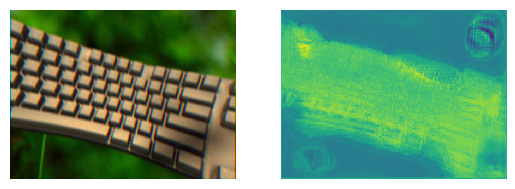

In [23]:
img, mask = valid_dataset.random_img()
pred = model.predict(img)

imshow(img, pred)
# imshow(pred > 1)